In [37]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import minmax_scale

from interactive_seg_backend.file_handling import load_image, load_labels
from interactive_seg_backend.main import featurise, train_and_apply, TrainingConfig, FeatureConfig

from yoeo.main import (
    get_hr_feats,
    get_dv2_model,
    get_upsampler_and_expr,
)
from yoeo.utils import convert_image, to_numpy, closest_crop, Experiment, do_2D_pca, add_flash_attention
from yoeo.comparisons.lift import ViTLiFTExtractor
from yoeo.comparisons.strided import StridedDv2

from PIL import Image
from skimage.color import label2rgb
import matplotlib.pyplot as plt

from typing import Any, Literal

SEED = 10673
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda:1"

FeatureTypes = Literal["classical", "dv2_nearest", "dv2_bilinear", "strided", "featup_jbu", "lift", "hr_vit"]

TODO:
- test ni supealloy/cracks (i.e small tertiary phases)
    - cracks is good: it's where we need to align the notions of particleness from deep feats with classical feats 
- overlay onto image

In [38]:
normal_dv2 = get_dv2_model(fit_3d=False, device=DEVICE)
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_full_fit_reg.pth"
cfg_path = "../yoeo/models/configs/combined_no_shift.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main


In [39]:
featup_jbu = torch.hub.load("mhamilton723/FeatUp", "dinov2", use_norm=True).to(DEVICE).eval()

Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [40]:
strided = StridedDv2('dinov2', 'vits14_reg', 1).to(DEVICE).eval()
strided.model = add_flash_attention(strided.model)

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [41]:
lift_path = "../trained_models/lift/lift_dino_vits8.pth"
lift = ViTLiFTExtractor('dino_vits8', lift_path=lift_path, channel=384, facet='key', device=DEVICE).eval()

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


Loaded Backbone: dino_vits8
Loaded LiFT module from: ../trained_models/lift/lift_dino_vits8.pth


In [42]:
@torch.no_grad()
def _our_featurise(img: Image.Image, dv2: torch.nn.Module, upsampler: torch.nn.Module, n_ch_in: int) -> np.ndarray:
    hr_feats = get_hr_feats(img, dv2, upsampler, DEVICE, n_ch_in=n_ch_in)
    hr_feats_np = to_numpy(hr_feats)
    reduced_hr = hr_feats_np[:3]
    return reduced_hr

@torch.no_grad()
def _original_featurise(img: Image.Image, dv2: torch.nn.Module, resize: str | None="nearest") -> np.ndarray:
    # _img = Image.open(path).convert("RGB")
    _h, _w = img.height, img.width
    tr = closest_crop(_h, _w)

    tensor = convert_image(img, tr, device_str=DEVICE)
    _, _, h, w = tensor.shape
    with torch.autocast("cuda", torch.float16):
        dino_feats = dv2.forward_features(tensor)['x_norm_patchtokens']
    n_patch_w, n_patch_h = w // 14, h // 14
    dino_feats = dino_feats.permute((0, 2, 1))
    dino_feats = dino_feats.reshape((1, -1, n_patch_h, n_patch_w,))
    if resize == "nearest":
        dino_feats = F.interpolate(dino_feats, (_h, _w), mode='nearest')
    elif resize == "bilinear":
        dino_feats = F.interpolate(dino_feats, (_h, _w), mode='bilinear')
    dino_feats_np = to_numpy(dino_feats)
    return dino_feats_np

@torch.no_grad()
def _jbu_featurise(img: Image.Image, jbu: torch.nn.Module) -> np.ndarray:
    # _img = Image.open(path).convert("RGB")
    _h, _w = img.height, img.width
    tr = closest_crop(_h, _w)

    tensor = convert_image(img, tr, device_str=DEVICE)
    with torch.autocast("cuda", torch.float16):
        jbu_feats = jbu(tensor.to(torch.float32))
    jbu_feats = F.interpolate(jbu_feats, (_h, _w))
    jbu_feats_np = to_numpy(jbu_feats)
    return jbu_feats_np[:3]

@torch.no_grad()
def _lift_featurise(path: str, img: Image.Image, lift: ViTLiFTExtractor, n: int=3, patch_size: int=8) -> np.ndarray:
    def closest_mult(x: int, p: int=8) -> int:
        return x - (x % p)
    tr_h, tr_w = closest_mult(img.height, 8), closest_mult(img.width, 8)
    _h, _w = img.height, img.width

    image_batch, _ = lift.preprocess(path, (tr_h, tr_w))
    image_batch = image_batch.to(DEVICE)

    with torch.autocast("cuda", torch.float16):
        lift_feats = lift.extract_descriptors_iterative_lift(image_batch, lift_iter=n)
    _, _, c = lift_feats.shape
    sf = int(patch_size / (2**n))
    reshaped = lift_feats.squeeze(0).T.reshape((1, c, tr_h // sf, tr_w //  sf))
    print(reshaped.shape)
    resized = F.interpolate(reshaped, (_h, _w))
    return to_numpy(resized)

@torch.no_grad()
def _strided_featurise(img: Image.Image, strided: StridedDv2) -> np.ndarray:
    # _img = Image.open(path).convert("RGB")
    _h, _w = img.height, img.width
    tr = closest_crop(_h, _w)

    tensor = convert_image(img, tr, device_str=DEVICE)
    with torch.autocast("cuda", torch.float16):
        strided_feats = strided(tensor)
    strided_feats = F.interpolate(strided_feats, (_h, _w))
    strided_feats_feats_np = to_numpy(strided_feats)
    return strided_feats_feats_np

In [43]:
PATH = "fig_data/supp_upsampler_choice"
tc = TrainingConfig(FeatureConfig(), classifier='xgb', classifier_params={'class_weight': 'balanced'})
# img_path = f"{PATH}/img_patch14.tif"
img_path = f"{PATH}/noisy_NMC_cracks.png"
img = Image.fromarray(load_image(f"{img_path}")).convert('RGB')
# labels = load_labels(f"{PATH}/labels_patch14_more.tiff")
labels = load_labels(f"{PATH}/noisy_nmc_labels_more.tiff")

In [44]:


def get_features(img: Image.Image, feat_type: FeatureTypes) -> tuple[np.ndarray, np.ndarray]:
    classical_feats = featurise(np.array(img), tc)
    if feat_type == "classical":
        return (classical_feats, classical_feats)
    elif feat_type == "dv2_nearest":
        deep_feats = _original_featurise(img, normal_dv2, 'nearest')
    elif feat_type == "dv2_bilinear":
        deep_feats = _original_featurise(img, normal_dv2, 'bilinear')
    elif feat_type == "strided":
        deep_feats = _strided_featurise(img, strided)
    elif feat_type == "featup_jbu":
        deep_feats = _jbu_featurise(img, featup_jbu)
    elif feat_type == "lift":
        deep_feats = _lift_featurise(img_path, img, lift)
    elif feat_type == "hr_vit":
        deep_feats = _our_featurise(img, dv2, upsampler, expr.n_ch_in)
    
    deep_feats = np.transpose(deep_feats, (1, 2, 0))
    return (classical_feats, deep_feats)

def rescale(arr: np.ndarray, swap_channels: bool=True) -> np.ndarray:
    if swap_channels:
        arr = np.transpose(arr, (1, 2, 0))
    h, w, c = arr.shape
    flat = arr.reshape((h * w, c))
    rescaled_flat = minmax_scale(flat)
    return rescaled_flat.reshape((h, w, c))

def get_feat_vis(feats: np.ndarray, feat_type: FeatureTypes) -> np.ndarray:
    if feat_type in ("featup_jbu", "hr_vit"):
        return rescale(feats[:, :, :3], swap_channels=False)
    else:
        tmp_transpose = feats.transpose((2, 0, 1))
        reduced = do_2D_pca(tmp_transpose, 3)
        reshaped = reduced.transpose((0, 1, 2))
        return rescale(reshaped, swap_channels=False)

In [51]:
features = ("classical", "dv2_nearest", "dv2_bilinear", "strided", "featup_jbu", "lift", "hr_vit")
res: dict[FeatureTypes, dict] = {}

for feat_type in features:
    print(feat_type)
    res[feat_type] = {}
    # if feat_type in ("strided", "lift", "featup_jbu"):
    #     res[feat_type]["feat_vis"] = np.zeros_like(np.array(img))
    #     res[feat_type]["pred"] = np.zeros_like(np.array(img))
    #     continue
    classical, deep = get_features(img, feat_type)
    feats = np.concatenate((classical, deep), -1)
    # feats = deep
    res[feat_type]["feat_vis"] = get_feat_vis(deep, feat_type)

    pred, _, _ = train_and_apply(feats, labels, tc)
    res[feat_type]["pred"] = pred

classical
dv2_nearest
dv2_bilinear
strided
featup_jbu
lift
torch.Size([1, 384, 576, 680])
hr_vit


In [52]:
cmap = [
            "#fafafa",
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
        ]
color_list = [[255, 255, 255], [31, 119, 180], [255, 127, 14], [44, 160, 44], [255, 0, 0]]
COLORS = np.array(color_list) / 255.0

In [53]:
def apply_labels_as_overlay(labels: np.ndarray, img: Image.Image, colors: list, alpha: float=1.0) -> Image.Image:
    labels_unsqueezed = np.expand_dims(labels, -1)

    overlay = label2rgb(labels, colors=colors[1:], kind='overlay', bg_label=0, image_alpha=1, alpha=alpha)
    out = np.where(labels_unsqueezed, overlay * 255, np.array(img)).astype(np.uint8)
    img_with_labels = Image.fromarray(out)
    return img_with_labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000000000002].


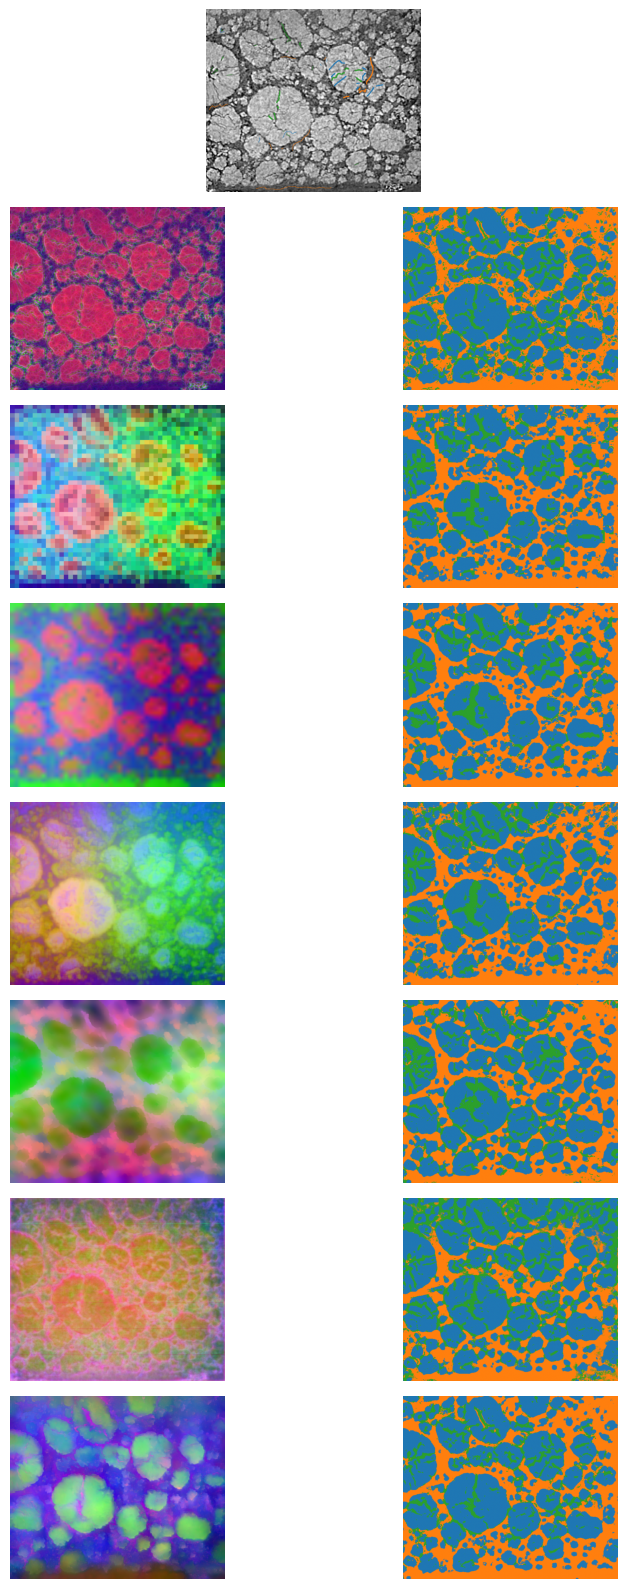

In [54]:
from matplotlib.gridspec import GridSpec

plt.rcParams["font.family"] = "serif"

TITLE_FS = 25
LABEL_FS = 23
TICK_FS = 21

width = 4
height = 2
N = len(features) + 1
fig = plt.figure(figsize=(width * 2, height * N))

gs = GridSpec(N, 2, figure=fig)

ax_top = fig.add_subplot(gs[0, :])  # Span across both column
img_with_labels = apply_labels_as_overlay(labels, img, colors=COLORS)
ax_top.imshow(img_with_labels)
ax_top.set_axis_off()

for i, (feat, subdict) in enumerate(res.items()):
    # if feat in ("strided", "lift", "featup_jbu"):
    #     continue
    feat_ax = fig.add_subplot(gs[i + 1, 0])
    feat_ax.imshow(subdict["feat_vis"])
    pred_ax = fig.add_subplot(gs[i + 1, 1])
    
    pred_ax.imshow(label2rgb(subdict["pred"] + 1, colors=COLORS[1:]))

    for ax in (feat_ax, pred_ax):
        ax.set_axis_off()


plt.tight_layout()
plt.show()

Image + labels at the top
For each method (classical, dv2_nearest, dv2_bilinear, strided, jbu, lift, ours) plot:
- vis of feat stack
- seg

torch.Size([1, 384, 576, 680])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000000000002].


(583, 683, 3)


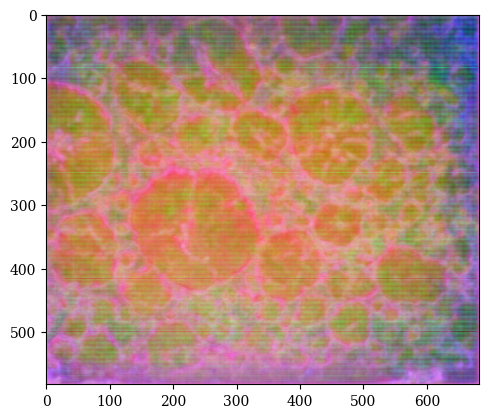

In [49]:



# _jbu_featurise(img, featup_jbu)
out = _lift_featurise(f"{img_path}", img, lift)
res = do_2D_pca(out)
print(res.shape)
plt.imshow(rescale(res, False))

In [50]:
out2 = _our_featurise(img, dv2, upsampler, expr)
res2 = out2[:3, :, :].transpose((1, 2, 0))
plt.imshow(rescale(res2, False))

TypeError: '>=' not supported between instances of 'Experiment' and 'int'

torch.Size([1, 3, 420, 784])
torch.Size([1, 1680, 384])
(420, 784, 3)


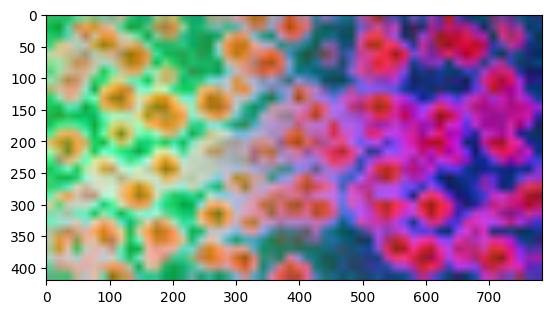

In [ ]:
out3 = _original_featurise(img, normal_dv2, 'bilinear')
res3 = do_2D_pca(out3)
print(res3.shape)
plt.imshow(rescale(res3, False))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


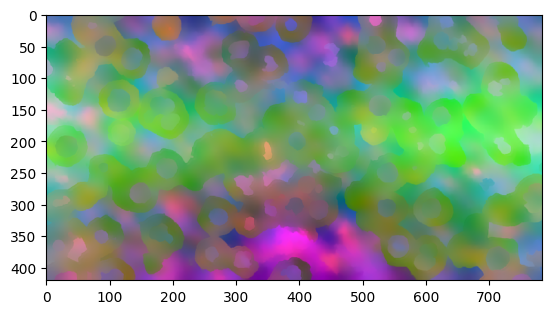

In [ ]:
out4 = _jbu_featurise(img, featup_jbu)
res4 = out4.transpose((1, 2, 0))
plt.imshow(rescale(res4, False))